In [1]:
"""@package docstring

SINTEO project
Copyright (C) 2022 ISAE-SUPAERO / ONERA

Description:
The aim of this notebook is to run and evaluate a DDR memory cost function equation 
for its posterior implementation within a multi-objective optimization framework.  
The cost function returns an estimated worst-case DDR memory interference cost for every task making up the task list.
Only one task per core is accepted. Each task/core accepts only one bank. Several tasks/cores can point to the same bank.
Unlike DDR_SDRAM_cost_function.ipynb, this file considers the access as a non-uniform cumulative distribution function.
Therefore, files describing the tasks properties are used instead of hardcoding them.

The current values present in this notebook is for the heterogenous Keystone II platform by Texas Instruments 
and its associated DDR3 memory controller, e.g., task properties, testing scenarios, DDR3 memory parameters. 


Creation date: 27/01/2022
Last modification date: 30/09/2022
Version: 1.1


Contact:
alfonso.mascarenas-gonzalez@isae-supaero.fr
jean-baptiste.chaudron@isae-supaero.fr
youcef.bouchebaba@onera.fr
frederic.boniol@onera.fr
jean-loup.bussenot@onera.fr
"""

'@package docstring\n\nSINTEO project\nCopyright (C) 2022 ISAE-SUPAERO / ONERA\n\nDescription:\nThe aim of this notebook is to run and evaluate a DDR memory cost function equation \nfor its posterior implementation within a multi-objective optimization framework.  \nThe cost function returns an estimated worst-case DDR memory interference cost for every task making up the task list.\nOnly one task per core is accepted. Each task/core accepts only one bank. Several tasks/cores can point to the same bank.\nUnlike DDR_SDRAM_cost_function.ipynb, this file considers the access as a non-uniform cumulative distribution function.\nTherefore, files describing the tasks properties are used instead of hardcoding them.\n\nThe current values present in this notebook is for the heterogenous Keystone II platform by Texas Instruments \nand its associated DDR3 memory controller, e.g., task properties, testing scenarios, DDR3 memory parameters. \n\n\nCreation date: 27/01/2022\nLast modification date: 30

In [2]:
# Import libraries
import copy # For performing deep copies
import math # For floor operations
import matplotlib.pyplot as plt # For plotting the results
import time # For the time analysis of the cost function
import csv # For reading CSV files

In [3]:
# To stop cells quietly
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def extract_tasks_properties(filename):
    """ Extracts the properties of a task from a CSV file. 
        Format: 'C', ['ACDF'], 'SP', 'S', 'ACOR' 

    Parameters:
    filename (string): Name (and path if necessary) of the CSV file defining the task properties.

    Returns:
    unsigned, unsigned (list), double, unsigned, double: 
    Execution time, accesses distribution, store proportion of accesses, bank row switches and ACOR

       """

    file = open(filename)
    csvreader = csv.reader(file)
    
    rows_list = []
    for row in csvreader:
        rows_list.append(row)
        
    acdf_list = rows_list[1][1].split(";") # Accesses distribution list creation
    acdf_list = [int(i) for i in acdf_list]
    
    file.close()
    
    
    return int(rows_list[1][0]), acdf_list, float(rows_list[1][2]), int(rows_list[1][3]), float(rows_list[1][4])


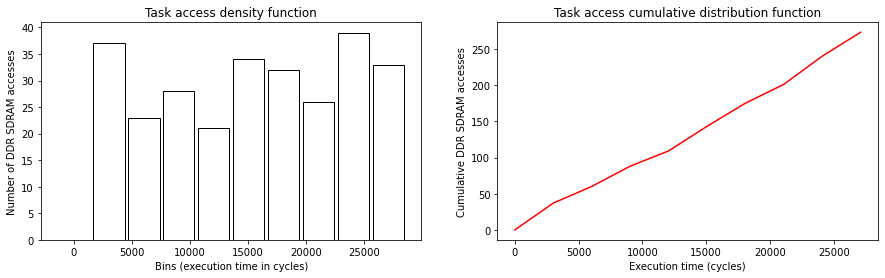

In [5]:
# Access CDF visualization
task_properties = extract_tasks_properties("./Task_Properties/task_0_arm.txt")
WCET = task_properties[0]
accesses_cdf = task_properties[1]

histogram_y = []
histogram_y.append(0) 
for i in range(len(accesses_cdf)-1):
    histogram_y.append(accesses_cdf[i+1] - accesses_cdf[i])

# x-axis 
x_axis = []
for i in range(len(accesses_cdf)):
    x_axis.append((i*WCET)/(len(accesses_cdf)-1))

plt.figure(figsize=(15, 4))  
plt.subplot(1, 2, 1) 
plt.bar(x_axis, histogram_y, fill=False, width=WCET/len(accesses_cdf)) 
plt.title("Task access density function")
plt.xlabel("Bins (execution time in cycles)")
plt.ylabel("Number of DDR SDRAM accesses")

plt.subplot(1, 2, 2) 
plt.plot(x_axis, accesses_cdf, color="red")
plt.title("Task access cumulative distribution function")
plt.xlabel("Execution time (cycles)")
plt.ylabel("Cumulative DDR SDRAM accesses")

plt.show()


In [6]:
# DDR SDRAM Paramaters constant variables
#########################################

CMD_BURST_THRESH = 4 # Size of the read and write commands batches (not watermaking policy)
NB_BANKS = 8 # Number of internal SDRAM banks

BL = 8 # Number of columns that can be accessed during a read or a write
CL = 11 # Elapsed time since the execution of a read command and the arrival of data
WL = 8 # Elapsed time since the execution of a write command and the arrival of data
t_CCD = BL/2 # Minimum time to leave between two CAS commands (read or write)
t_WR = 12 # Time from the last burst write cycle until a precharge can be issued to the same bank
t_RTP = 6 # Delay between a read command execution and a row bank precharge
t_WTR = 6 # Write to read turnaround time
t_RP = 11 # Deactivation time of an opened row of a bank (precharge command)
t_RRD = 6 # Minimum time separation of two consecutive active commands to different banks
t_FAW = 24 # Time window where maximum four consecutive active commands can be issued
t_RCD = 11 # Activation time of a closed row of a bank (active command)


# Conversion constant variables
###############################

DDR_CORE_FREQ_CONV = 1.5 # Frequency conversion from the DDR memory controller to the cores frequency (core_freq / controller_freq)

In [7]:
class Task():
    
   def __init__(self, ID: int, load: int, access: list, SP: float, LP: float, ACOR: float, PE: int, PE_type: int, bank: int, row_switches: int, period: int):
        """Constructor for the class Task. Initializes the task properties. 

        Parameters:
        ID (int): Identification of the task to be mapped.
        load (int): Worst-case execution time in isolation. Units: cycles
        access (list): Cumulative distribution of the maximum number of DDR memory accesses in isolation. 
        SP (float): Proportion of stores of the DDR memory accesses. [0,1]
        LP (float): Proportion of loads of the DDR memory accesses. [0,1]
        ACOR (float): Average Commands per Opened Row during a maximum interference scenario
        PE (int): PE identification
        bank (int): Bank identification
        row_switches (int): Number of row switches in isolation
        period (int): Execution period of the task. Units: cycles

        Returns:
        Nothing 

       """
        self.id = ID
        self.load = load
        self.access = access
        self.SP = SP
        self.LP = LP  
        self.ACOR = ACOR
        self.PE = PE
        self.PE_type = PE_type
        self.bank = bank
        self.row_switches = row_switches
        self.period = period

    
class Platform():

   def __init__(self, nb_PE: int, nb_banks: int, nb_tasks: int):
        """Constructor for the class Platform. Initializes the platform properties. 

        Parameters:
        nb_PE (int): Total number of Processing Elements (PEs) on the platform
        nb_banks (int): Total number of banks on the DDR memory controller of the platform
        nb_tasks (int): Total number of tasks to be used on the platform 

        Returns:
        Nothing 

        """        
        self.nb_PE = nb_PE
        self.nb_banks = nb_banks
        self.nb_tasks = nb_tasks
        

In [8]:
def accesses_cdf(cdf_hist, total_load, time_stamp):
    """Returns the total number of SDRAM accesses issued before the specified time. 

    Parameters:
    cdf_hist (list): List with the cumulative accesses as function of the histogram bins 
                     (the index of the list is the bin identification)
    total_load (unsigned): Total execution time of the task 
    time_stamp (unsigned): Unit of time up to which we want to recover the total number of accesses 

    Returns:
    unsigned: The cumulative number of accesses

   """
    
    if len(cdf_hist) == 0:
        print("Task access list is empty. Stopping execution...")
        raise StopExecution
        
    if time_stamp >= total_load:
        return cdf_hist[len(cdf_hist)-1]
    
    bin_dbl = (len(cdf_hist)-1) * (time_stamp/total_load)
    acc = cdf_hist[math.ceil(bin_dbl)]
    
    return acc

def get_number_of_external_banks_used(tasks_list):
    """Calculates the number of banks other than the one of the task under anlysis. 

    Parameters:
    task_list (list): List with all the tasks involved

    Returns:
    double: The total store or load proportion of intra-bank interfering tasks
    double: The total store or load proportion of inter-bank interfering tasks

   """
    banks_list = [0] * ptf.nb_banks

    for j in range(len(tasks_list)): 
        banks_list[tasks_list[j].bank] = 1    
            
    return (sum(banks_list)-1)


def get_number_of_accesses_in_bank(tasks_list, task_ua_index, bank_id):
    """Calculates the number of accesses to a specific bank. 

    Parameters:
    tasks_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task to analysis
    bank_id (unsigned): ID of the bank to explore

    Returns:
    unsigned: The total number of access to the specified bank

   """
    number_of_accesses = 0

    for j in range(len(tasks_list)):
        if tasks_list[j].bank == bank_id:
            RIE_dbl = RIE(tasks_list, task_ua_index, j)
            RIE_int = math.floor(RIE_dbl)
            RIE_dec = RIE_dbl - RIE_int
            acdf = RIE_int*tasks_list[j].access[len(tasks_list[j].access)-1] + \
                   accesses_cdf(tasks_list[j].access, tasks_list[j].load, tasks_list[task_ua_index].load*RIE_dec)
            
            number_of_accesses = number_of_accesses + acdf
        
    return number_of_accesses

           

In [9]:
global ptf


def total_access_proportion(task_list, task_ua_index, instr): 
    """Calculates the global store or load proportion from the task under analysis by considering all the tasks.
    It differentiates between intra-bank and inter-bank store or load proportion. 

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task to analysis
    instr (string): To select either the store or load proportion to calculate. 
                    'SP' for the store proportion
                    'LP' for the load proportion

    Returns:
    double: The total store or load proportion of intra-bank interfering tasks
    double: The total store or load proportion of inter-bank interfering tasks

   """
        
    total_proportion_intra = 0
    total_proportion_inter = 0
    
    proportion_list_intra = []
    proportion_list_inter = []

    if instr == 'SP':
        for i in range(len(task_list)):
            if i == task_ua_index:
                continue
            if task_list[i].bank == task_list[task_ua_index].bank:
                proportion_list_intra.append(task_list[i].SP)
            else:
                proportion_list_inter.append(task_list[i].SP)

    elif instr == 'LP':   
        for i in range(len(task_list)):
            if i == task_ua_index:
                continue
            if task_list[i].bank == task_list[task_ua_index].bank:
                proportion_list_intra.append(task_list[i].LP)
            else:
                proportion_list_inter.append(task_list[i].LP)
                
    if len(proportion_list_intra) != 0:
        total_proportion_intra = sum(proportion_list_intra) / len(proportion_list_intra)
    
    if len(proportion_list_inter) != 0:
        total_proportion_inter = sum(proportion_list_inter) / len(proportion_list_inter)
            
    return total_proportion_intra, total_proportion_inter 


def PGNCL(task_list, task_ua_index):
    """Calculates the number of command in the queue line that execute before the selected task from a task list 
    considering periodic conditions and distinguishing between intra-bank and inter-bank interference

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task under analysis

    Returns:
    double: The number of worst-case intra-bank interfering accesses
    double: The number of worst-case inter-bank interfering accesses

   """
    ncl_intra = 0;
    ncl_inter = 0;

    task_ua = task_list[task_ua_index] 
    
    # Iterate through all the interfering tasks and compute the number of access interfering task_ua
    for t in range(len(task_list)):
        if t == task_ua_index:
            continue
            
        RIE_dbl = RIE(task_list, task_ua_index, t)
        RIE_int = math.floor(RIE_dbl)
        RIE_dec = RIE_dbl - RIE_int
           
        acdf = RIE_int*task_list[t].access[len(task_list[t].access)-1] + \
               accesses_cdf(task_list[t].access, task_list[t].load, task_list[task_ua_index].load*RIE_dec)
        
        if task_list[task_ua_index].bank == task_list[t].bank:
            ncl_intra = ncl_intra + acdf
        else:
            ncl_inter = ncl_inter + acdf

    return ncl_intra, ncl_inter 


def CBS(tasks_list, task_ua_index):
    """ Computes the wort-case size of the read/write bacthes, i.e., the Command Batch Size (CBS)  

    Parameters:
    tasks_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task under analysis

    Returns:
    double: The command batch size for the given task under analysis

   """
    relative_cbs = 0
    task_ua_bank = tasks_list[task_ua_index].bank
    number_of_accesses_of_bank_ua = get_number_of_accesses_in_bank(tasks_list, task_ua_index, task_ua_bank)
    
    for k in range(ptf.nb_banks):
        if k == task_ua_bank:
            continue
        relative_cbs = relative_cbs + min(get_number_of_accesses_in_bank(tasks_list, task_ua_index, k)/number_of_accesses_of_bank_ua, 1)

    cbs = 1 + min(relative_cbs, CMD_BURST_THRESH)
    
    return cbs 


def RIE(task_list, task_ua_index, taks_j_index):
    """ Returns the Relative Interference Exposition (RIE) from the given tasks, 
    i.e., the amount of time a task can affect another assuming a uniform distribution

    Parameters:
    task_list (list): List with all the interfering tasks involved
    task_ua_index (unsigned): Task under analisys index
    taks_j_index (unsigned): The index of an interfering task 

    Returns:
    double: The RIE value

   """

    task_ua = task_list[task_ua_index] 
    task_j = task_list[taks_j_index]

    # (1) Calculate the number of task_j executions that affect the task_ua. 
    # Monoperiodic cases ignore this (task_ua.load < task_j.period).
    # (2) Calculate the proportion of time task_j affects by task_ua within an single execution
    # task_ua can't be affected more than one entirely time by task_j within an single execution, therefore limited to 1.
    RIE = \
    ( \
     math.floor(task_ua.load / task_j.period)  # (1)
     + min( (task_ua.load - math.floor(task_ua.load/task_j.period) * task_j.period)/task_j.load, 1 )  # (2)
    )

    return RIE 

def calculate_row_switches_quantity(task_list, task_ua_index):
    """Calculates the number of row switched that the task under anlysis suffers from 
    the interfering tasks pointing to the same and external banks (intra and inter)

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task to analyze

    Returns:
    double: The number of worst-case intra-bank row switches
    double: The number of worst-case inter-bank row switches

   """
    rs_intra = 0;
    rs_inter = 0;
    task_ua = task_list[task_ua_index] 
    task_ua_access_acor = task_ua.access[len(task_ua.access)-1]/task_list[task_ua_index].ACOR

    # Check for all banks in the platform
    for bank_id in range(ptf.nb_banks):
        nb_cores = 0
        rs_inter_bank = 0
        
        # Compute the number of cores pointing to bank bank_id
        for t in range(len(task_list)):
            if task_list[t].bank == bank_id:
                nb_cores = nb_cores + 1          
        
        # Check how many accesses affect the task under analysis
        for t in range(len(task_list)):
            if task_list[t].bank != bank_id:
                continue
            if t == task_ua_index:
                continue
            
            RIE_dbl = RIE(task_list, task_ua_index, t)
            RIE_int = math.floor(RIE_dbl)
            RIE_dec = RIE_dbl - RIE_int
           
            acdf = RIE_int*task_list[t].access[len(task_list[t].access)-1] + \
               accesses_cdf(task_list[t].access, task_list[t].load, task_list[task_ua_index].load*RIE_dec)
        
            # Intra-bank interfering accesses
            if task_list[t].bank == task_ua.bank:
                rs_intra = rs_intra + min(acdf/task_list[t].ACOR, \
                                          task_ua_access_acor)
            # Inter-bank interfering accesses    
            else:
                # Affected by the intrinsic interfering task row switches
                if(nb_cores == 1):
                    rs_inter_bank = task_list[t].row_switches * RIE(task_list, task_ua_index, t)
                # Number of times an interfering task row switch is produced by opening a closed row forced by another interfering task to the same bank   
                else:
                    rs_inter_bank = rs_inter_bank + acdf/task_list[t].ACOR
         
        rs_inter = rs_inter + min(task_ua_access_acor, rs_inter_bank)
        

    return  (rs_intra, rs_inter) 

def interference_cost_calculation(task_list, task_ua_index):
    """ Returns the Relative Interference Exposition (RIE) from the given tasks

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (int): Task under analisys index from the task list

    Returns:
    double: The DDR interference cost for the the task under analysis

   """

    taks_ua = task_list[task_ua_index]
    nb_external_banks = get_number_of_external_banks_used(task_list)
    
    # Compute the number of intra-bank and inter-bank interfering accesses 
    PGNCL_intra, PGNCL_inter = PGNCL(task_list, task_ua_index)

    # Compute the turnaround write and read transmission cost for intra-bank and inter-bank interference cases
    WT_intra = WL + BL/2 + t_WTR
    RT_intra = CL + BL/2 + 2
    WT_inter = WL + BL/2 + t_WTR
    RT_inter = CL + BL/2 + 2 - WL 
        
    # Compute the total Store and Load proportion
    SPT_intra, SPT_inter = total_access_proportion(task_list, task_ua_index, 'SP')
    LPT_intra, LPT_inter = total_access_proportion(task_list, task_ua_index, 'LP')
    
    cbs = CBS(task_list, task_ua_index)
    
    # Caclulate the DDR3 interfering cost
    cmd_cost_intra = (1/cbs)*PGNCL_intra*(SPT_intra*WT_intra + LPT_intra*RT_intra) \
                     + (1 - 1/cbs)*PGNCL_intra*BL/2
    cmd_cost_inter = (1/cbs)*PGNCL_inter*(SPT_inter*WT_inter + LPT_inter*RT_inter) \
                     + (1- 1/cbs)*PGNCL_inter*BL/2
    
    # Calculate the intra-bank row switch cost
    row_switch_cost_intra = max(t_RTP, t_WR) + t_RP + t_RCD + max(WL, CL)
    
    # Calculate the inter-bank row switch cost
    if nb_external_banks < 4:
        row_switch_cost_inter = 1 + t_RRD 
    else:
        row_switch_cost_inter = 1 + t_FAW - 3*t_RRD

    #Calculate the number of row switches and cost
    rs_intra, rs_inter = calculate_row_switches_quantity(task_list, task_ua_index)
    total_row_sw_cost_intra = rs_intra*row_switch_cost_intra
    total_row_sw_cost_inter = rs_inter*row_switch_cost_inter
    
    # Interference cost
    impact = cmd_cost_intra + cmd_cost_inter + total_row_sw_cost_intra + total_row_sw_cost_inter    
    
    
    return impact



In [10]:
def DDR_interference_recursive_cost_function(task_list, nb_iterations):
    """Calculates recursively the DDR interference cost for all the task from a task list

    Parameters:
    task_list (list): List with the original tasks involved
    nb_iterations (unsigned): Number of times we are looping to leave the model converge sufficiently.
                              Values 4 and 5 are good enough for the tested scenarios.

    Returns:
    double (list): The worst DDR3 interference cost for the all the tasks

   """
    
    task_WCET_list_temp = [0]*len(task_list) # Keeps rencently calculated interference
    task_list_iter = copy.deepcopy(task_list) # Keeps the task list interference values outcome at the end of an iteration

    # Start the recursive calculation of the interference cost.
    # Alternatively to nb_iterations, an infinite loop can be used, analyze the last measurements to see if it converges and return
    for j in range(nb_iterations):
        results_string = "Iter: " + str(j) + ": "
        # Calculate the new execution time for a given task considering the interference from other tasks
        for i in range(len(task_list)):
            # Calculate interference and add it to the original value considering the clock frequency difference
            new_WCET = task_list[i].load + DDR_CORE_FREQ_CONV*interference_cost_calculation(task_list_iter, i)
            task_WCET_list_temp[i] = new_WCET
            results_string = results_string + " " + str("{:.2f}".format(new_WCET))

        # Update tasks properties for the next interation
        for cnt in range(len(task_list)):
            task_list_iter[cnt].load = task_WCET_list_temp[cnt]
                
        print(results_string)     

    return task_list_iter 


def DDR_interference_recursive_cost_function_debug(task_list, nb_iterations, nb_repetitions):
    """ Prints the execution time of recursively calculating the DDR interference cost for all the task 
        from a task list

    Parameters:
    task_list (list): List with the original tasks involved
    nb_iterations (unsigned): Number of times we are looping to leave the model converge sufficiently.
                              Values 4 and 5 are good enough for the tested scenarios.
    nb_repetitions (unsigned): Number of times the cost function is executed for measuring its execution time 

    Returns:
    double (list): The worst DDR3 interference cost for the all the tasks

   """
    
    SEC_2_MS = 1000
    
    start_time = time.time() # First time

    task_WCET_list_temp = [0]*len(task_list) # Keeps rencently calculated interference
    task_list_iter = copy.deepcopy(task_list) # Keeps the task list interference values outcome at the end of an iteration

    # Iterate many times for obtaining a reliable execution time profiling
    for reps in range(nb_repetitions):
        # Start the recursive calculation of the interference cost.
        # Alternatively to nb_iterations, an infinite loop can be used, analyze the last measurements to see if it converges and return
        for j in range(nb_iterations):
            # Calculate the new execution time for a given task considering the interference from other tasks
            for i in range(len(task_list)):
                # Calculate interference and add it to the original value considering the clock frequency difference
                new_WCET = task_list[i].load + DDR_CORE_FREQ_CONV*interference_cost_calculation(task_list_iter, i)
                task_WCET_list_temp[i] = new_WCET
            # Update tasks properties for the next interation
            for cnt in range(len(task_list)):
                task_list_iter[cnt].load = task_WCET_list_temp[cnt]

    end_time = time.time()
    time_diff = SEC_2_MS*(end_time - start_time)/nb_repetitions
    time_diff_per_iter = time_diff/nb_iterations

    print("--- Total execution time: %s ms ---" % time_diff)     
    print("--- Execution time per algorithm iteration: %s ms ---" % time_diff_per_iter)         

    return task_list_iter 

In [11]:
global ptf

task_list = []

NB_TASKS = 8
NB_PEs = 8 # 8 cores out of 12 available ones (Keystone II TCI6636K2H MPSoC where 4 are ARM Cortex A15 and 8 are C66x DSP)

T1 = 1200000 # Period 1 (cycles)
T2 = 60000 # Period 2 (cycles)
 
# Read files with the profiling information of the tasks
task_0_arm_properties_list = extract_tasks_properties("./Task_Properties/task_0_arm.txt")
task_0_dsp_properties_list = extract_tasks_properties("./Task_Properties/task_0_dsp.txt")
task_1_arm_properties_list = extract_tasks_properties("./Task_Properties/task_1_arm.txt")
task_1_dsp_properties_list = extract_tasks_properties("./Task_Properties/task_1_dsp.txt")
    
# ARM Cortex A15 and DSP C66x profiling of two dummy tasks types for demonstration purposes
task_load_ARM = [task_0_arm_properties_list[0], task_0_arm_properties_list[0], task_0_arm_properties_list[0], 
                 task_0_arm_properties_list[0], task_1_arm_properties_list[0], task_1_arm_properties_list[0], 
                 task_1_arm_properties_list[0], task_1_arm_properties_list[0]] 
task_load_DSP = [task_0_dsp_properties_list[0], task_0_dsp_properties_list[0], task_0_dsp_properties_list[0], 
                 task_0_dsp_properties_list[0], task_1_dsp_properties_list[0], task_1_dsp_properties_list[0], 
                 task_1_dsp_properties_list[0], task_1_dsp_properties_list[0]] 
task_access_ARM = [task_0_arm_properties_list[1], task_0_arm_properties_list[1], task_0_arm_properties_list[1], 
                  task_0_arm_properties_list[1], task_1_arm_properties_list[1], task_1_arm_properties_list[1], 
                  task_1_arm_properties_list[1], task_1_arm_properties_list[1]] 
task_access_DSP = [task_0_dsp_properties_list[1], task_0_dsp_properties_list[1], task_0_dsp_properties_list[1], 
                  task_0_dsp_properties_list[1], task_1_dsp_properties_list[1], task_1_dsp_properties_list[1], 
                  task_1_dsp_properties_list[1], task_1_dsp_properties_list[1]] 
task_SP_ARM = [task_0_arm_properties_list[2], task_0_arm_properties_list[2], task_0_arm_properties_list[2], 
               task_0_arm_properties_list[2], task_1_arm_properties_list[2], task_1_arm_properties_list[2], 
               task_1_arm_properties_list[2], task_1_arm_properties_list[2]] 
task_SP_DSP = [task_0_dsp_properties_list[2], task_0_dsp_properties_list[2], task_0_dsp_properties_list[2], 
               task_0_dsp_properties_list[2], task_1_dsp_properties_list[2], task_1_dsp_properties_list[2], 
               task_1_dsp_properties_list[2], task_1_dsp_properties_list[2]]  
task_LP_ARM = [1-task_SP_ARM[0], 1-task_SP_ARM[1], 1-task_SP_ARM[2], 1-task_SP_ARM[3], 
               1-task_SP_ARM[4], 1-task_SP_ARM[5], 1-task_SP_ARM[6], 1-task_SP_ARM[7]] 
task_LP_DSP = [1-task_SP_DSP[0], 1-task_SP_DSP[1], 1-task_SP_DSP[2], 1-task_SP_DSP[3], 
               1-task_SP_DSP[4], 1-task_SP_DSP[5], 1-task_SP_DSP[6], 1-task_SP_DSP[7]] 
task_row_switches_ARM = [task_0_arm_properties_list[3], task_0_arm_properties_list[3], task_0_arm_properties_list[3], 
               task_0_arm_properties_list[3], task_1_arm_properties_list[3], task_1_arm_properties_list[3], 
               task_1_arm_properties_list[3], task_1_arm_properties_list[3]] 
task_row_switches_DSP = [task_0_dsp_properties_list[3], task_0_dsp_properties_list[3], task_0_dsp_properties_list[3], 
               task_0_dsp_properties_list[3], task_1_dsp_properties_list[3], task_1_dsp_properties_list[3], 
               task_1_dsp_properties_list[3], task_1_dsp_properties_list[3]] 
task_ACOR_ARM = [task_0_arm_properties_list[4], task_0_arm_properties_list[4], task_0_arm_properties_list[4], 
               task_0_arm_properties_list[4], task_1_arm_properties_list[4], task_1_arm_properties_list[4], 
               task_1_arm_properties_list[4], task_1_arm_properties_list[4]] 
task_ACOR_DSP = [task_0_dsp_properties_list[4], task_0_dsp_properties_list[4], task_0_dsp_properties_list[4], 
               task_0_dsp_properties_list[4], task_1_dsp_properties_list[4], task_1_dsp_properties_list[4], 
               task_1_dsp_properties_list[4], task_1_dsp_properties_list[4]] 
# Designer dependent information
task_PE = [0, 1, 2, 3, 4, 5, 6, 7] # PE to run the task
task_PE_type = [0, 0, 1, 1, 1, 1, 1, 1] # ARM Cortex A15 = 0; C66x DSP = 1; 
task_bank = [0, 1, 0, 0, 1, 1, 2, 2] 
task_period = [T1, T1, T1, T1, T1, T1, T1, T1]


# Create the task list, differentiating between ARM (1st in list, i.e., 0) ad DSP (2nd in list, i.e., 1) values 
# when applicable. 
for i in range(NB_TASKS):
    task_list.append(Task(i, 
                          [task_load_ARM[i], task_load_DSP[i]],
                          [task_access_ARM[i], task_access_DSP[i]],  
                          [task_SP_ARM[i], task_SP_DSP[i]], 
                          [task_LP_ARM[i], task_LP_DSP[i]], 
                          [task_ACOR_ARM[i], task_ACOR_DSP[i]], 
                          task_PE[i], 
                          task_PE_type[i],
                          task_bank[i], 
                          [task_row_switches_ARM[i], task_row_switches_DSP[i]],
                          task_period[i])
                        )
        
# Initialize the platform
ptf = Platform(NB_PEs, NB_BANKS, NB_TASKS)

# Update values of the tasks from the list according to its PE (0,1 = ARM; 2-7 = DSP). 
# Modify determine_PE_type function for changing the PE value meaning.
for index in range(len(task_list)):
    task_list[index].load = task_list[index].load[task_list[index].PE_type]
    task_list[index].access = task_list[index].access[task_list[index].PE_type]
    task_list[index].SP = task_list[index].SP[task_list[index].PE_type]
    task_list[index].LP = task_list[index].LP[task_list[index].PE_type]
    task_list[index].ACOR = task_list[index].ACOR[task_list[index].PE_type]
    task_list[index].row_switches = task_list[index].row_switches[task_list[index].PE_type]
    task_list[index].period = task_list[index].period

    
pe_accum = []

print("Tasks original execution time: ", task_list[0].load, task_list[1].load, task_list[2].load, task_list[3].load, \
      task_list[4].load, task_list[5].load, task_list[6].load, task_list[7].load)
    
    
# Run the cost function equation iteratively
NB_ITER = 8
NB_REPETITIONS = 1000

# Shows the SDRAM interference value at each iteration step
# pe_accum = DDR_interference_recursive_cost_function(task_list, NB_ITER)

# Prints the execution time profiling of the cost function
pe_accum = DDR_interference_recursive_cost_function_debug(task_list, NB_ITER, NB_REPETITIONS)
    
    
results = "Normalized WCET: "
normalized_interfered_execution_list = []

for j in range(len(task_list)):
    normalized_interfered_execution_list.append(pe_accum[j].load/task_list[j].load)
    results = results + " " + str("{:.2f}".format(normalized_interfered_execution_list[j]))
    
print(results)
            
        

Tasks original execution time:  27102 27102 24102 24102 49207 49207 49207 49207
--- Total execution time: 5.195481777191162 ms ---
--- Execution time per algorithm iteration: 0.6494352221488953 ms ---
Normalized WCET:  2.30 1.98 2.42 2.42 2.23 2.23 1.99 1.99


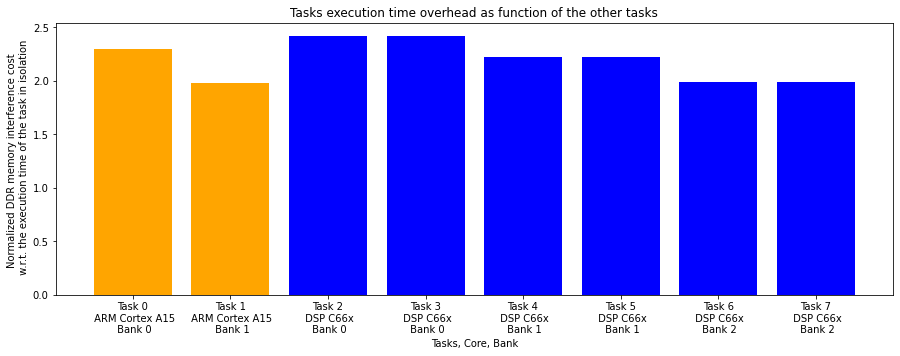

In [12]:
# This cell is used for plotting the results obtained in the previous cell

color_list = []
tick_label = []

# Modify figure parameters as function of the core type.
for i in range(len(task_list)):
    if task_list[i].PE_type == 0:
        color_list.append('orange')
        tick_label.append('Task ' + str(i) + '\n ARM Cortex A15' + '\n Bank ' + str(task_list[i].bank))
    elif task_list[i].PE_type == 1:
        color_list.append('blue')
        tick_label.append('Task ' + str(i) + '\n DSP C66x' + '\n Bank ' + str(task_list[i].bank))
        
# x-coordinates of left sides of bars
left = []
for i in range(len(task_list)):
    left.append(i)
  
plt.figure(figsize=(15, 5))  # width: 15, height: 5
plt.bar(left, normalized_interfered_execution_list, tick_label = tick_label,
        width = 0.8, color = color_list)
 

plt.xlabel('Tasks, Core, Bank')
plt.ylabel('Normalized DDR memory interference cost \n w.r.t. the execution time of the task in isolation')
plt.title('Tasks execution time overhead as function of the other tasks')
 
plt.show()